Cargué la base de datos Khan.csv y revisé que no hubiera NaN para después imprimir las primeras 5 filas, así como sus dimensiones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.stats.multitest import multipletests 
import scipy.stats 


df = pd.read_csv("Khan.csv")
print (df.shape)
df.head()

(83, 2309)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X2300,X2301,X2302,X2303,X2304,X2305,X2306,X2307,X2308,y
0,0.773344,-2.438405,-0.482562,-2.721135,-1.217058,0.827809,1.342604,0.057042,0.133569,0.565427,...,-0.027474,-1.660205,0.588231,-0.463624,-3.952845,-5.496768,-1.414282,-0.647600,-1.763172,2
1,-0.078178,-2.415754,0.412772,-2.825146,-0.626236,0.054488,1.429498,-0.120249,0.456792,0.159053,...,-0.246284,-0.836325,-0.571284,0.034788,-2.478130,-3.661264,-1.093923,-1.209320,-0.824395,2
2,-0.084469,-1.649739,-0.241308,-2.875286,-0.889405,-0.027474,1.159300,0.015676,0.191942,0.496585,...,0.024985,-1.059872,-0.403767,-0.678653,-2.939352,-2.736450,-1.965399,-0.805868,-1.139434,2
3,0.965614,-2.380547,0.625297,-1.741256,-0.845366,0.949687,1.093801,0.819736,-0.284620,0.994732,...,0.357115,-1.893128,0.255107,0.163309,-1.021929,-2.077843,-1.127629,0.331531,-2.179483,2
4,0.075664,-1.728785,0.852626,0.272695,-1.841370,0.327936,1.251219,0.771450,0.030917,0.278313,...,0.061753,-2.273998,-0.039365,0.368801,-2.566551,-1.675044,-1.082050,-0.965218,-1.836966,2


Aquí separé las muestras de clase 2 y clase 4. Para cada gen calculé las medias por clase y la diferencia (2–4). Mostré el top-10 por diferencia (con signo y por magnitud). Esto me dio candidatos a expresión diferencial entre 2 y 4; es una señal útil para formular hipótesis, pero no prueba significancia por sí sola (de ahí el siguiente inciso con pruebas y correcciones).
Y con esto podremos determinar cuales genes tienen mayor diferencia entre clases, y que pueden afectar a que se desarrolle la enfermedad.

In [4]:
y = df["y"].astype(int)
X = df.drop(columns=["y"])
print("Huecos:", df.isna().sum().sum())

grupo_1 = df.loc[df["y"] == 1]
grupo_2 = df.loc[df["y"] == 2]
grupo_3 = df.loc[df["y"] == 3]
grupo_4 = df.loc[df["y"] == 4]

print("Tamaño de la clase 2:", grupo_2.shape[0])

media_c2 = grupo_2.mean(axis=0).drop("y")
media_c4 = grupo_4.mean(axis=0).drop("y")

delta_abs = (media_c2 - media_c4).abs()

top10 = delta_abs.sort_values(ascending=False).head(10)
print(top10)

Huecos: 0
Tamaño de la clase 2: 29
X187     3.323151
X509     2.906537
X2046    2.424515
X2050    2.401783
X129     2.165185
X1645    2.065460
X1319    2.045941
X1955    2.037340
X1003    2.011337
X246     1.837830
dtype: float64


Apliqué un t-test por gen (2 vs 4) y obtuve un p-value para cada uno. Como son muchas pruebas, apliqué Bonferroni, Holm y BH-FDR con α=0.05.Puse cuántos genes quedaron significativos con cada método y listé los más significativos según el p ajustado. Tal como se espera, Bonferroni/Holm (más conservadores) detectaron menos genes, mientras que BH-FDR retuvo más candidatos aceptables. Estos datos sí nos dan evidencia estadística de diferencia de expresión entre 2 y 4.

In [7]:
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
import pandas as pd

genes = [c for c in df.columns if c != "y"]

p_vals = []
t_stats = []
for g in genes:
    t_stat, p_val = stats.ttest_ind(grupo_2[g], grupo_4[g])  
    t_stats.append(t_stat)
    p_vals.append(p_val)

resultados_t = pd.DataFrame({
    "Gene": genes,
    "t_stat": t_stats,
    "p_value": p_vals
}).sort_values("p_value").reset_index(drop=True)

alpha = 0.05
rej_bonf, p_bonf, _, _ = multipletests(resultados_t["p_value"], alpha=alpha, method="bonferroni")
rej_holm, p_holm, _, _ = multipletests(resultados_t["p_value"], alpha=alpha, method="holm")
rej_bh,   p_bh,   _, _ = multipletests(resultados_t["p_value"], alpha=alpha, method="fdr_bh")

resultados_t["p_bonf"] = p_bonf
resultados_t["p_holm"] = p_holm
resultados_t["p_bh"]   = p_bh
resultados_t["sig_bonf"] = rej_bonf
resultados_t["sig_holm"] = rej_holm
resultados_t["sig_bh"]   = rej_bh

print("Genes significativos (2 vs 4) con α=0.05")
print("  Bonferroni:", int(resultados_t["sig_bonf"].sum()))
print("  Holm      :", int(resultados_t["sig_holm"].sum()))
print("  BH-FDR    :", int(resultados_t["sig_bh"].sum()))

print("\nTop-10 Bonferroni:")
print(resultados_t[resultados_t["sig_bonf"]].sort_values("p_bonf")[["Gene","p_bonf"]].head(10))

print("\nTop-10 Holm:")
print(resultados_t[resultados_t["sig_holm"]].sort_values("p_holm")[["Gene","p_holm"]].head(10))

print("\nTop-10 BH-FDR:")
print(resultados_t[resultados_t["sig_bh"]].sort_values("p_bh")[["Gene","p_bh"]].head(10))


Genes significativos (2 vs 4) con α=0.05
  Bonferroni: 74
  Holm      : 74
  BH-FDR    : 297

Top-10 Bonferroni:
    Gene        p_bonf
0  X1955  1.115244e-14
1  X1003  1.125576e-14
2   X187  5.845306e-13
3  X2046  9.108119e-12
4  X2050  1.017132e-11
5   X509  1.874319e-11
6  X1645  3.196477e-11
7   X246  5.379259e-11
8  X1954  3.313313e-10
9  X1389  4.838102e-10

Top-10 Holm:
    Gene        p_holm
0  X1955  1.115244e-14
1  X1003  1.125089e-14
2   X187  5.840241e-13
3  X2046  9.096280e-12
4  X2050  1.015370e-11
5   X509  1.870259e-11
6  X1645  3.188168e-11
7   X246  5.362944e-11
8  X1954  3.301829e-10
9  X1389  4.819236e-10

Top-10 BH-FDR:
    Gene          p_bh
0  X1955  5.627882e-15
1  X1003  5.627882e-15
2   X187  1.948435e-13
3  X2046  2.034265e-12
4  X2050  2.034265e-12
5   X509  3.123866e-12
6  X1645  4.566396e-12
7   X246  6.724074e-12
8  X1954  3.681459e-11
9  X1389  4.838102e-11


Estratifiqué el dataset en cuatro clases (1–4) y, para cada gen, apliqué ANOVA de una vía con scipy.stats.f_oneway. Ordené los p-values y apliqué las mismas tres correcciones (Bonferroni, Holm, BH-FDR) con α = 0.05.
Puse cuantos genes quedaron significativos en cada método y mostré un top bajo FDR.
ANOVA detecta diferencias globales entre clases, pero no especifica qué pares difieren; si fuera necesario, propondría pruebas post-hoc para ubicar las comparaciones específicas.

In [8]:
from scipy.stats import f_oneway
import pandas as pd

clase1 = df[df["y"] == 1]
clase2 = df[df["y"] == 2]
clase3 = df[df["y"] == 3]
clase4 = df[df["y"] == 4]

p_vals_anova = []
f_stats = []
for g in genes:
    f_stat, p_val = f_oneway(clase1[g], clase2[g], clase3[g], clase4[g])
    f_stats.append(f_stat)
    p_vals_anova.append(p_val)

resultados_a = pd.DataFrame({
    "Gene": genes,
    "f_stat": f_stats,
    "p_value": p_vals_anova
}).sort_values("p_value").reset_index(drop=True)

rej_bonf_a, p_bonf_a, _, _ = multipletests(resultados_a["p_value"], alpha=0.05, method="bonferroni")
rej_holm_a, p_holm_a, _, _ = multipletests(resultados_a["p_value"], alpha=0.05, method="holm")
rej_bh_a,   p_bh_a,   _, _ = multipletests(resultados_a["p_value"], alpha=0.05, method="fdr_bh")

resultados_a["p_bonf"] = p_bonf_a
resultados_a["p_holm"] = p_holm_a
resultados_a["p_bh"]   = p_bh_a
resultados_a["sig_bonf"] = rej_bonf_a
resultados_a["sig_holm"] = rej_holm_a
resultados_a["sig_bh"]   = rej_bh_a

print("Genes significativos (ANOVA 4 clases) con α=0.05")
print("  Bonferroni:", int(resultados_a["sig_bonf"].sum()))
print("  Holm      :", int(resultados_a["sig_holm"].sum()))
print("  BH-FDR    :", int(resultados_a["sig_bh"].sum()))

print("\nTop-10 BH-FDR (ANOVA):")
print(resultados_a[resultados_a["sig_bh"]].sort_values("p_bh")[["Gene","p_bh"]].head(10))


Genes significativos (ANOVA 4 clases) con α=0.05
  Bonferroni: 404
  Holm      : 412
  BH-FDR    : 1162

Top-10 BH-FDR (ANOVA):
    Gene          p_bh
0  X1955  2.045755e-21
1  X1389  2.045755e-21
2  X1003  1.245542e-20
3  X2050  2.731346e-19
4   X246  3.062126e-19
5   X742  8.445542e-19
6     X1  1.265852e-17
7  X2162  2.986387e-17
8  X1954  5.597246e-17
9  X1645  6.751740e-17


A partir de los resultados anteriores, seleccioné un subconjunto pequeño de los genes mas significativos por ANOVA para reducir el costo computacional.
Realicé un split estratificado train/test (70/30) y entrené tres SVM: lineal, polinomial (grado 3) y RBF.
esta selección de variables con la base completa implica fuga de datos; lo correcto sería seleccionar características solo con el set de entrenamiento (o dentro de validación cruzada).

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

X = df.drop(columns=["y"])
y = df["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

modelo_lineal = SVC(kernel="linear", C=1)
modelo_lineal.fit(X_train, y_train)

modelo_cubico = SVC(kernel="poly", degree=3, C=1)
modelo_cubico.fit(X_train, y_train)

modelo_rbf = SVC(kernel="rbf", C=1)
modelo_rbf.fit(X_train, y_train)

y_pred_lin = modelo_lineal.predict(X_test)
y_pred_cub = modelo_cubico.predict(X_test)
y_pred_rbf = modelo_rbf.predict(X_test)

print("Accuracy lineal:", accuracy_score(y_test, y_pred_lin))
print("Accuracy cúbico:", accuracy_score(y_test, y_pred_cub))
print("Accuracy RBF   :", accuracy_score(y_test, y_pred_rbf))

print("F1 lineal:", f1_score(y_test, y_pred_lin, average="weighted"))
print("F1 cúbico:", f1_score(y_test, y_pred_cub, average="weighted"))
print("F1 RBF:", f1_score(y_test, y_pred_rbf, average="weighted"))


Accuracy lineal: 1.0
Accuracy cúbico: 0.92
Accuracy RBF   : 1.0
F1 lineal (weighted): 1.0
F1 cúbico (weighted): 0.9144444444444444
F1 RBF (weighted)   : 1.0


Calculé accuracy y F1 en el conjunto de prueba y grafiqué las matrices de confusión de los tres kernels.
En las matrices de confusión, lineal y RBF quedaron diagonales perfectas mientras que el polinomial de grado 3 confundió principalmente clase 3 vs 4. Con esto, concluyo que lineal y RBF se comportaron mejor y de forma equivalente en mi split; y el polinomial fue inferior. 
Para una conclusión más robusta podríamos normalizar features, seleccionar genes dentro de train/CV y repetir con validación cruzada.

Accuracy Lineal: 1.000 | poli g=3: 0.920 | rbf: 1.000
F1    Lineal: 1.000 | poli g=3: 0.914 | rbf: 1.000


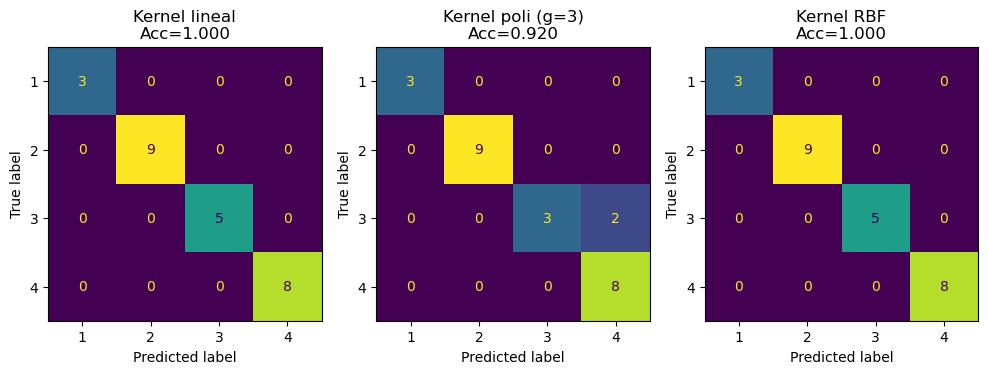

In [28]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

acc_lin  = accuracy_score(y_test, y_pred_lin)
acc_cub = accuracy_score(y_test, y_pred_cub)
acc_rbf  = accuracy_score(y_test, y_pred_rbf)

f1_lin  = f1_score(y_test, y_pred_lin, average="weighted")
f1_cub = f1_score(y_test, y_pred_cub, average="weighted")
f1_rbf  = f1_score(y_test, y_pred_rbf, average="weighted")

print(f"Accuracy Lineal: {acc_lin:.3f} | poli g=3: {acc_cub:.3f} | rbf: {acc_rbf:.3f}")
print(f"F1    Lineal: {f1_lin:.3f} | poli g=3: {f1_cub:.3f} | rbf: {f1_rbf:.3f}")

labels = sorted(np.unique(y_test))
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

cm1 = confusion_matrix(y_test, y_pred_lin,  labels=labels)
cm2 = confusion_matrix(y_test, y_pred_cub, labels=labels)
cm3 = confusion_matrix(y_test, y_pred_rbf,  labels=labels)

ConfusionMatrixDisplay(cm1, display_labels=labels).plot(ax=axes[0], colorbar=False)
axes[0].set_title(f"Kernel lineal\nAcc={acc_lin:.3f}")

ConfusionMatrixDisplay(cm2, display_labels=labels).plot(ax=axes[1], colorbar=False)
axes[1].set_title(f"Kernel poli (g=3)\nAcc={acc_cub:.3f}")

ConfusionMatrixDisplay(cm3, display_labels=labels).plot(ax=axes[2], colorbar=False)
axes[2].set_title(f"Kernel RBF\nAcc={acc_rbf:.3f}")

plt.show()